### Deep Neural Network for SOC Prediction with using LG 18650HG2 Li-ion Battery

LG 18650HG2 Li-ion Battery DataSet - https://data.mendeley.com/datasets/cp3473x7xv/3

In [40]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
PROCESSED_DATA_DIR = '../../datasets/LG_dataset/LG_HG2_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [49]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [6]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [41]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [11]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [17]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-08 09:53:14,0.000000,0.000,4.18936,-0.05108,23.34519,0.00000,0.000000,0.000000,1.005569,0,562_Mixed6_processed.csv,-0.213993
1,2018-11-08 09:53:14,0.010033,0.602,4.18784,-0.09450,23.34519,-0.00001,0.000029,-0.000015,0.999995,1,562_Mixed6_processed.csv,-0.395751
2,2018-11-08 09:53:15,0.025017,1.501,4.18767,-0.09450,23.34519,-0.00004,0.000028,-0.000039,0.999987,2,562_Mixed6_processed.csv,-0.395735
3,2018-11-08 09:53:16,0.041700,2.502,4.18750,-0.09450,23.34519,-0.00006,0.000028,-0.000065,0.999977,3,562_Mixed6_processed.csv,-0.395719
4,2018-11-08 09:53:17,0.059983,3.599,4.18734,-0.09195,23.34519,-0.00009,0.000028,-0.000093,0.999966,4,562_Mixed6_processed.csv,-0.385026
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532257,2018-12-18 18:24:55,112.126150,6727.569,3.48709,0.00000,-9.77974,-2.10860,0.000027,-2.112200,0.170802,6728,604_Mixed8_processed.csv,0.000000
532258,2018-12-18 18:24:56,112.142883,6728.573,3.48726,0.00000,-9.77974,-2.10860,0.000028,-2.112200,0.170802,6729,604_Mixed8_processed.csv,0.000000
532259,2018-12-18 18:24:57,112.159483,6729.569,3.48726,0.00000,-9.77974,-2.10860,0.000027,-2.112200,0.170802,6730,604_Mixed8_processed.csv,0.000000
532260,2018-12-18 18:24:58,112.176183,6730.571,3.48726,0.00000,-9.77974,-2.10860,0.000029,-2.112200,0.170802,6731,604_Mixed8_processed.csv,0.000000


In [18]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-08 09:53:14,0.000000,0.000,1.693907,0.421254,0.821057,0.00000,0.000000,1.531129,1.005569,0,562_Mixed6_processed.csv,0.410519
1,2018-11-08 09:53:14,0.010033,0.602,1.688779,0.402139,0.821057,-0.00001,0.000029,1.531109,0.999995,1,562_Mixed6_processed.csv,0.387702
2,2018-11-08 09:53:15,0.025017,1.501,1.688205,0.402139,0.821057,-0.00004,0.000028,1.531078,0.999987,2,562_Mixed6_processed.csv,0.387704
3,2018-11-08 09:53:16,0.041700,2.502,1.687632,0.402139,0.821057,-0.00006,0.000028,1.531044,0.999977,3,562_Mixed6_processed.csv,0.387707
4,2018-11-08 09:53:17,0.059983,3.599,1.687092,0.403262,0.821057,-0.00009,0.000028,1.531006,0.999966,4,562_Mixed6_processed.csv,0.389049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532257,2018-12-18 18:24:55,112.126150,6727.569,-0.675525,0.443741,-0.992532,-2.10860,0.000027,-1.259410,0.170802,6728,604_Mixed8_processed.csv,0.437382
532258,2018-12-18 18:24:56,112.142883,6728.573,-0.674951,0.443741,-0.992532,-2.10860,0.000028,-1.259410,0.170802,6729,604_Mixed8_processed.csv,0.437382
532259,2018-12-18 18:24:57,112.159483,6729.569,-0.674951,0.443741,-0.992532,-2.10860,0.000027,-1.259410,0.170802,6730,604_Mixed8_processed.csv,0.437382
532260,2018-12-18 18:24:58,112.176183,6730.571,-0.674951,0.443741,-0.992532,-2.10860,0.000029,-1.259410,0.170802,6731,604_Mixed8_processed.csv,0.437382


In [25]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [26]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [30]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [50]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [32]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'571_Mixed8_processed.csv', '604_Mixed8_processed.csv', '552_Mixed5_processed.csv', '611_PausCycl_processed.csv', '551_Cap_1C_processed.csv', '590_Mixed8_processed.csv', '610_Mixed2_processed.csv', '576_UDDS_processed.csv', '589_Mixed1_processed.csv', '567_Mixed2_processed.csv', '575_HPPC_processed.csv', '590_Mixed7_processed.csv', '610_HWFET_processed.csv', '571_Mixed6_processed.csv', '571_Cap_1C_processed.csv', '604_PausCycl_processed.csv', '604_Mixed6_processed.csv', '551_US06_processed.csv', '562_Mixed7_processed.csv', '596_Cap_1C_processed.csv', '607_HPPC_processed.csv', '556_US06_processed.csv', '552_Mixed7_processed.csv', '601_Mixed1_processed.csv', '604_Mixed3_processed.csv', '611_Mixed6_processed.csv', '601_Mixed2_processed.csv', '593_HPPC_processed.csv', '571_Mixed5_processed.csv', '556_LA92_processed.csv', '589_HWFET_processed.csv', '611_Mixed7_processed.csv', '571_Mixed7_processed.csv', '562_PausCycl_processed.csv', '611_Mixed8_processed.csv', '610_LA92_pro

In [34]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([428714, 5])
Test features shape: torch.Size([51159, 5])
Train labels shape: torch.Size([428714])
Test labels shape: torch.Size([51159])


## Hyperparameter tuning

In [35]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [37]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-07-31 02:03:43,212] A new study created in memory with name: no-name-0e1c149c-5bad-49c8-b29e-5cfc8ecc85c5


Epoch 1/10, Train Loss: 0.552569653676517, Validation Loss: 0.40709959215870717
Time taken for epoch: 5.89416409 seconds
Epoch 2/10, Train Loss: 0.2850483434413796, Validation Loss: 0.21080995665454283
Time taken for epoch: 5.94137216 seconds
Epoch 3/10, Train Loss: 0.14258644320626757, Validation Loss: 0.09474071431450727
Time taken for epoch: 5.87443495 seconds
Epoch 4/10, Train Loss: 0.0722172497963505, Validation Loss: 0.02847316652371707
Time taken for epoch: 6.01033401 seconds
Epoch 5/10, Train Loss: 0.04597630193206801, Validation Loss: 0.011898759735969638
Time taken for epoch: 5.93726397 seconds
Epoch 6/10, Train Loss: 0.035626123392426254, Validation Loss: 0.00928381674298069
Time taken for epoch: 5.89879608 seconds
Epoch 7/10, Train Loss: 0.0296171941916778, Validation Loss: 0.006136502421754924
Time taken for epoch: 6.52018285 seconds
Epoch 8/10, Train Loss: 0.025119011288147364, Validation Loss: 0.004916062895662014
Time taken for epoch: 6.34201765 seconds
Epoch 9/10, Trai

[I 2025-07-31 02:04:48,425] Trial 0 finished with value: 0.005423351812736455 and parameters: {'learning_rate': 1.2134238849578614e-05, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.1775031944298925}. Best is trial 0 with value: 0.005423351812736455.


Epoch 10/10, Train Loss: 0.019189808117086763, Validation Loss: 0.005423351812736455
Time taken for epoch: 6.18677711 seconds
Epoch 1/10, Train Loss: 0.006784048840097749, Validation Loss: 0.0016366788297135627
Time taken for epoch: 5.34630895 seconds
Epoch 2/10, Train Loss: 0.004008835892735133, Validation Loss: 0.0006848443637287213
Time taken for epoch: 5.33714414 seconds
Epoch 3/10, Train Loss: 0.003968608128045922, Validation Loss: 0.0019270589437549394
Time taken for epoch: 5.21671200 seconds
Epoch 4/10, Train Loss: 0.00403127741579439, Validation Loss: 0.0021515408129568533
Time taken for epoch: 4.99520707 seconds
Epoch 5/10, Train Loss: 0.003985719566907623, Validation Loss: 0.004287796644922953
Time taken for epoch: 5.15435815 seconds
Epoch 6/10, Train Loss: 0.003984099249737754, Validation Loss: 0.0011306688006221166
Time taken for epoch: 5.48734689 seconds
Epoch 7/10, Train Loss: 0.003996171695771001, Validation Loss: 0.00474176621837836
Time taken for epoch: 5.35704398 seco

[I 2025-07-31 02:05:44,159] Trial 1 finished with value: 0.000951375566295965 and parameters: {'learning_rate': 0.0029829205432656512, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.1178970545432422}. Best is trial 1 with value: 0.000951375566295965.


Epoch 10/10, Train Loss: 0.00399542353946521, Validation Loss: 0.000951375566295965
Time taken for epoch: 5.52983618 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.06305459467721963, Validation Loss: 0.011830770254874085
Time taken for epoch: 5.06686306 seconds
Epoch 2/10, Train Loss: 0.020762411923106038, Validation Loss: 0.006829379542605461
Time taken for epoch: 4.93774009 seconds
Epoch 3/10, Train Loss: 0.013278255729115944, Validation Loss: 0.005230027985884945
Time taken for epoch: 4.98697090 seconds
Epoch 4/10, Train Loss: 0.00953927923424809, Validation Loss: 0.004600961777173214
Time taken for epoch: 5.19649839 seconds
Epoch 5/10, Train Loss: 0.007083885282305862, Validation Loss: 0.003602997292586135
Time taken for epoch: 5.06775284 seconds
Epoch 6/10, Train Loss: 0.005300668293624115, Validation Loss: 0.002686451705626607
Time taken for epoch: 5.23645782 seconds
Epoch 7/10, Train Loss: 0.004058430324475378, Validation Loss: 0.0019897750276158615
Time taken for ep

[I 2025-07-31 02:06:38,116] Trial 2 finished with value: 0.0006770203665227444 and parameters: {'learning_rate': 2.701060252058222e-05, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.11595065817250463}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.0019714722608619216, Validation Loss: 0.0006770203665227444
Time taken for epoch: 5.22286105 seconds
Epoch 1/10, Train Loss: 0.007195391566284112, Validation Loss: 0.0020976210205134985
Time taken for epoch: 4.47138190 seconds
Epoch 2/10, Train Loss: 0.0070469055037055885, Validation Loss: 0.006076117612411043
Time taken for epoch: 4.29123926 seconds
Epoch 3/10, Train Loss: 0.00723852315584003, Validation Loss: 0.005683396928610064
Time taken for epoch: 4.21917105 seconds
Epoch 4/10, Train Loss: 0.007403003119502161, Validation Loss: 0.0033562886496195173
Time taken for epoch: 4.49196386 seconds
Epoch 5/10, Train Loss: 0.007438995793406198, Validation Loss: 0.0009486144142944639
Time taken for epoch: 4.28651786 seconds
Epoch 6/10, Train Loss: 0.007478751890125004, Validation Loss: 0.007455994813178067
Time taken for epoch: 4.50720596 seconds
Epoch 7/10, Train Loss: 0.007511128001679569, Validation Loss: 0.0031986872386790687
Time taken for epoch: 4.32681179 s

[I 2025-07-31 02:07:24,839] Trial 3 finished with value: 0.005034158680694129 and parameters: {'learning_rate': 0.038029054870166, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.28303883943087893}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.007913702690014755, Validation Loss: 0.005034158680694129
Time taken for epoch: 4.51960802 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.008198537288525544, Validation Loss: 0.0009022976833410034
Time taken for epoch: 8.21904778 seconds
Epoch 2/10, Train Loss: 0.005578233976917925, Validation Loss: 0.0010447302247146625
Time taken for epoch: 7.93833089 seconds
Epoch 3/10, Train Loss: 0.0056186386557129115, Validation Loss: 0.0013415354958008876
Time taken for epoch: 8.06430793 seconds
Epoch 4/10, Train Loss: 0.005600013537471419, Validation Loss: 0.0008932966641322498
Time taken for epoch: 8.25380492 seconds
Epoch 5/10, Train Loss: 0.00566537260543555, Validation Loss: 0.0014059361892893832
Time taken for epoch: 7.88327789 seconds
Epoch 6/10, Train Loss: 0.005608684721527927, Validation Loss: 0.002241080239837618
Time taken for epoch: 8.15880823 seconds
Early stopping triggered
Epoch 7/10, Train Loss: 0.00562903544594492, Validation Loss: 0.00089

[I 2025-07-31 02:08:48,386] Trial 4 finished with value: 0.0016799560517694505 and parameters: {'learning_rate': 0.0012725693738550392, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.32188677756142564}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.005662180696085874, Validation Loss: 0.0016799560517694505
Time taken for epoch: 7.79067802 seconds
Epoch 1/10, Train Loss: 0.06858851125602847, Validation Loss: 0.002196388443757669
Time taken for epoch: 4.41406989 seconds
Epoch 2/10, Train Loss: 0.005030634793306965, Validation Loss: 0.000642952357508498
Time taken for epoch: 4.60672379 seconds
Epoch 3/10, Train Loss: 0.00374542411538397, Validation Loss: 0.0007492251440224642
Time taken for epoch: 4.17361927 seconds
Epoch 4/10, Train Loss: 0.00380489063574307, Validation Loss: 0.0007865340357952278
Time taken for epoch: 4.09869432 seconds
Epoch 5/10, Train Loss: 0.0038140769783101642, Validation Loss: 0.0007900512082215289
Time taken for epoch: 4.20980215 seconds
Epoch 6/10, Train Loss: 0.003863033553335204, Validation Loss: 0.0006670821644170579
Time taken for epoch: 4.48642182 seconds
Epoch 7/10, Train Loss: 0.003876855000436528, Validation Loss: 0.0007691633811726583
Time taken for epoch: 4.30938411 sec

[I 2025-07-31 02:09:36,271] Trial 5 finished with value: 0.0007585368893266948 and parameters: {'learning_rate': 0.00023430628713949004, 'hidden_size': 16, 'num_layers': 1, 'dropout_rate': 0.17639535252548014}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.003871788048227109, Validation Loss: 0.0007585368893266948
Time taken for epoch: 5.19913507 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.07887192074709864, Validation Loss: 0.0667292608804329
Time taken for epoch: 8.93107891 seconds
Epoch 2/10, Train Loss: 0.07068323377909055, Validation Loss: 0.06413835503854211
Time taken for epoch: 9.12572813 seconds
Epoch 3/10, Train Loss: 0.0706389511899272, Validation Loss: 0.06329826347993686
Time taken for epoch: 9.10600495 seconds
Epoch 4/10, Train Loss: 0.07474118733027978, Validation Loss: 0.07814501732221554
Time taken for epoch: 9.06753683 seconds
Epoch 5/10, Train Loss: 0.08422176056611004, Validation Loss: 0.07692706978353205
Time taken for epoch: 9.66348696 seconds
Epoch 6/10, Train Loss: 0.08418851326539445, Validation Loss: 0.07752742327807914
Time taken for epoch: 8.35402584 seconds
Epoch 7/10, Train Loss: 0.08425256225377765, Validation Loss: 0.07676523024777164
Time taken for epoch: 8.799605

[I 2025-07-31 02:11:11,061] Trial 6 finished with value: 0.07839135896679514 and parameters: {'learning_rate': 0.01585366718139898, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.47283376174323244}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.08422066597128983, Validation Loss: 0.07839135896679514
Time taken for epoch: 9.20135188 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.015535203317013472, Validation Loss: 0.0011319588309644554
Time taken for epoch: 7.27531528 seconds
Epoch 2/10, Train Loss: 0.007864293125249557, Validation Loss: 0.0009559279048155199
Time taken for epoch: 8.07716680 seconds
Epoch 3/10, Train Loss: 0.007884322972273204, Validation Loss: 0.002377547089613555
Time taken for epoch: 8.24192715 seconds
Epoch 4/10, Train Loss: 0.007915986626506296, Validation Loss: 0.0010066974227012863
Time taken for epoch: 8.43309307 seconds
Epoch 5/10, Train Loss: 0.00788201014830995, Validation Loss: 0.0019081760215421358
Time taken for epoch: 7.97276211 seconds
Epoch 6/10, Train Loss: 0.00793019809913057, Validation Loss: 0.0019212195723930675
Time taken for epoch: 8.18396688 seconds
Epoch 7/10, Train Loss: 0.007922537294980972, Validation Loss: 0.0014784523812467363
Time taken fo

[I 2025-07-31 02:12:35,268] Trial 7 finished with value: 0.0012832527516729343 and parameters: {'learning_rate': 0.0004953108314230988, 'hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3192697563646647}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.007945015372208028, Validation Loss: 0.0012832527516729343
Time taken for epoch: 8.09880900 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.009236778845948014, Validation Loss: 0.0005383003262132555
Time taken for epoch: 4.77329016 seconds
Epoch 2/10, Train Loss: 0.0033046202097477308, Validation Loss: 0.0007151532936009561
Time taken for epoch: 5.50927401 seconds
Epoch 3/10, Train Loss: 0.003280423750697788, Validation Loss: 0.0005872744512799261
Time taken for epoch: 5.31996107 seconds
Epoch 4/10, Train Loss: 0.0033091516558901033, Validation Loss: 0.0008191449175353579
Time taken for epoch: 4.79878783 seconds
Epoch 5/10, Train Loss: 0.00331461134154711, Validation Loss: 0.001204177228276133
Time taken for epoch: 4.65063500 seconds
Epoch 6/10, Train Loss: 0.0032836466910553847, Validation Loss: 0.0005283463189609792
Time taken for epoch: 4.39401507 seconds
Early stopping triggered
Epoch 7/10, Train Loss: 0.0033091266276731863, Validation Loss: 0.

[I 2025-07-31 02:13:27,157] Trial 8 finished with value: 0.0009186563312471485 and parameters: {'learning_rate': 0.0011775673502570012, 'hidden_size': 16, 'num_layers': 1, 'dropout_rate': 0.1284036956128829}. Best is trial 2 with value: 0.0006770203665227444.


Epoch 10/10, Train Loss: 0.003320464378174172, Validation Loss: 0.0009186563312471485
Time taken for epoch: 4.95396996 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.06488658447736012, Validation Loss: 0.0033760409618258653
Time taken for epoch: 7.93460083 seconds
Epoch 2/10, Train Loss: 0.010378338634453492, Validation Loss: 0.0016465409438454134
Time taken for epoch: 8.14992189 seconds
Epoch 3/10, Train Loss: 0.004691446116611139, Validation Loss: 0.0004632961865644382
Time taken for epoch: 7.84351683 seconds
Epoch 4/10, Train Loss: 0.003493584967565848, Validation Loss: 0.0005593963142673158
Time taken for epoch: 7.85538507 seconds
Epoch 5/10, Train Loss: 0.003011517341825555, Validation Loss: 0.0005508597832278899
Time taken for epoch: 7.80462098 seconds
Epoch 6/10, Train Loss: 0.0026761904969088623, Validation Loss: 0.000253834475462299
Time taken for epoch: 8.34464812 seconds
Epoch 7/10, Train Loss: 0.0024254575592757605, Validation Loss: 0.00036609177690952323
Time t

[I 2025-07-31 02:14:48,795] Trial 9 finished with value: 0.0003084866943536867 and parameters: {'learning_rate': 4.9759535984065307e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.26751264808600395}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.00242797276092026, Validation Loss: 0.0003084866943536867
Time taken for epoch: 6.98163295 seconds
Epoch 1/10, Train Loss: 0.052660394303167046, Validation Loss: 0.0044992402670109965
Time taken for epoch: 7.14950681 seconds
Epoch 2/10, Train Loss: 0.006485560532770495, Validation Loss: 0.0006496172276168115
Time taken for epoch: 7.76002598 seconds
Epoch 3/10, Train Loss: 0.004349536238474522, Validation Loss: 0.0006018439028616185
Time taken for epoch: 7.15553308 seconds
Epoch 4/10, Train Loss: 0.003928631681656993, Validation Loss: 0.0004271883146117261
Time taken for epoch: 6.58527279 seconds
Epoch 5/10, Train Loss: 0.003925872718560885, Validation Loss: 0.0004498671063956641
Time taken for epoch: 6.53900409 seconds
Epoch 6/10, Train Loss: 0.003940562713654962, Validation Loss: 0.0004216108945872581
Time taken for epoch: 6.50332689 seconds
Epoch 7/10, Train Loss: 0.003940497368935551, Validation Loss: 0.0007172688016691786
Time taken for epoch: 7.38009381 

[I 2025-07-31 02:16:04,189] Trial 10 finished with value: 0.0005837270135205517 and parameters: {'learning_rate': 0.00010707384387512222, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.42902055828933755}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.003934970452318162, Validation Loss: 0.0005837270135205517
Time taken for epoch: 7.58104014 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.06944307288877777, Validation Loss: 0.009562363847047858
Time taken for epoch: 7.70450783 seconds
Epoch 2/10, Train Loss: 0.009742457627930414, Validation Loss: 0.002150069150369435
Time taken for epoch: 7.89112711 seconds
Epoch 3/10, Train Loss: 0.005810310009158035, Validation Loss: 0.0007041336512867663
Time taken for epoch: 8.14545035 seconds
Epoch 4/10, Train Loss: 0.0048334669847903185, Validation Loss: 0.0005918300679384424
Time taken for epoch: 7.51626992 seconds
Epoch 5/10, Train Loss: 0.004506239990856665, Validation Loss: 0.0010329136762762393
Time taken for epoch: 8.33575892 seconds
Epoch 6/10, Train Loss: 0.004558137346948705, Validation Loss: 0.000696613085758544
Time taken for epoch: 7.27183318 seconds
Epoch 7/10, Train Loss: 0.004537419218208585, Validation Loss: 0.0005704563055435135
Time taken

[I 2025-07-31 02:17:22,986] Trial 11 finished with value: 0.0003419821040723968 and parameters: {'learning_rate': 8.13621667492758e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4702589232035154}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.004585415745195724, Validation Loss: 0.0003419821040723968
Time taken for epoch: 6.74125504 seconds
Epoch 1/10, Train Loss: 0.09419784047043146, Validation Loss: 0.009914812799145627
Time taken for epoch: 6.98403668 seconds
Epoch 2/10, Train Loss: 0.014523175040593566, Validation Loss: 0.003793354693652041
Time taken for epoch: 6.98021126 seconds
Epoch 3/10, Train Loss: 0.007250501810322835, Validation Loss: 0.001668621691963536
Time taken for epoch: 7.88548112 seconds
Epoch 4/10, Train Loss: 0.005446446097956331, Validation Loss: 0.0011622829556411421
Time taken for epoch: 7.59636140 seconds
Epoch 5/10, Train Loss: 0.00463320812224341, Validation Loss: 0.0016395770622391578
Time taken for epoch: 7.33315301 seconds
Epoch 6/10, Train Loss: 0.004073724957711216, Validation Loss: 0.0005757368260191936
Time taken for epoch: 7.15126920 seconds
Epoch 7/10, Train Loss: 0.003909084575612154, Validation Loss: 0.0005771390065024484
Time taken for epoch: 7.18051410 seco

[I 2025-07-31 02:18:40,280] Trial 12 finished with value: 0.0004846753376047517 and parameters: {'learning_rate': 5.772993892053643e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.39673133374780883}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.003993458020389636, Validation Loss: 0.0004846753376047517
Time taken for epoch: 6.96283317 seconds
Epoch 1/10, Train Loss: 0.03203298086411695, Validation Loss: 0.0028398257137646063
Time taken for epoch: 7.80694628 seconds
Epoch 2/10, Train Loss: 0.005019511845477147, Validation Loss: 0.0012731121877947186
Time taken for epoch: 7.39944983 seconds
Epoch 3/10, Train Loss: 0.0033289556595177128, Validation Loss: 0.00037425531061937987
Time taken for epoch: 7.61438990 seconds
Epoch 4/10, Train Loss: 0.0026102592393325, Validation Loss: 0.0002778378601631841
Time taken for epoch: 7.90531492 seconds
Epoch 5/10, Train Loss: 0.0024535684732706355, Validation Loss: 0.0003665934525928406
Time taken for epoch: 7.44607520 seconds
Epoch 6/10, Train Loss: 0.002406104321021642, Validation Loss: 0.0002696042405968205
Time taken for epoch: 7.87587309 seconds
Epoch 7/10, Train Loss: 0.002406784709883548, Validation Loss: 0.00022710985678613946
Time taken for epoch: 7.5133130

[I 2025-07-31 02:20:00,534] Trial 13 finished with value: 0.0003414370647974243 and parameters: {'learning_rate': 9.417807520671815e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.251248596662357}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.002404487852021051, Validation Loss: 0.0003414370647974243
Time taken for epoch: 7.71209693 seconds
Epoch 1/10, Train Loss: 0.7232149768765292, Validation Loss: 0.40107788886965773
Time taken for epoch: 11.65312910 seconds
Epoch 2/10, Train Loss: 0.25339439616496884, Validation Loss: 0.131364712428029
Time taken for epoch: 10.81760716 seconds
Epoch 3/10, Train Loss: 0.08983087579928227, Validation Loss: 0.026295776110960217
Time taken for epoch: 11.17984986 seconds
Epoch 4/10, Train Loss: 0.04924921143077203, Validation Loss: 0.008640947515041483
Time taken for epoch: 10.05824494 seconds
Epoch 5/10, Train Loss: 0.033752969991582546, Validation Loss: 0.005735332404060622
Time taken for epoch: 11.82100821 seconds
Epoch 6/10, Train Loss: 0.024384100950364748, Validation Loss: 0.00286777412638628
Time taken for epoch: 12.39240026 seconds
Epoch 7/10, Train Loss: 0.0189336316017851, Validation Loss: 0.0030326841951691455
Time taken for epoch: 11.82824993 seconds
Ep

[I 2025-07-31 02:21:55,623] Trial 14 finished with value: 0.0008644905818394963 and parameters: {'learning_rate': 1.2876037099816239e-05, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.25081125536025173}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.011194346562278138, Validation Loss: 0.0008644905818394963
Time taken for epoch: 10.02504110 seconds
Epoch 1/10, Train Loss: 0.010621738348872081, Validation Loss: 0.0008751591917549589
Time taken for epoch: 9.05742693 seconds
Epoch 2/10, Train Loss: 0.0020880058652429437, Validation Loss: 0.0004754691350327204
Time taken for epoch: 8.85835004 seconds
Epoch 3/10, Train Loss: 0.0017792483033619321, Validation Loss: 0.0005212226470370652
Time taken for epoch: 8.70087194 seconds
Epoch 4/10, Train Loss: 0.001778610467062846, Validation Loss: 0.0002566039445431526
Time taken for epoch: 8.81169677 seconds
Epoch 5/10, Train Loss: 0.00176815455769008, Validation Loss: 0.0015741945446166028
Time taken for epoch: 8.62530994 seconds
Epoch 6/10, Train Loss: 0.0018185043996269466, Validation Loss: 0.00020891789000282787
Time taken for epoch: 9.25023413 seconds
Epoch 7/10, Train Loss: 0.0017622949472114221, Validation Loss: 0.0004521885013639487
Time taken for epoch: 9.099

[I 2025-07-31 02:23:29,270] Trial 15 finished with value: 0.00033352979043015915 and parameters: {'learning_rate': 0.0002517024614693027, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.24749926014501572}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.0017642359575256706, Validation Loss: 0.00033352979043015915
Time taken for epoch: 8.92193699 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.0073099185356091875, Validation Loss: 0.0029381164259553415
Time taken for epoch: 12.97151995 seconds
Epoch 2/10, Train Loss: 0.007510837701969405, Validation Loss: 0.0008140581248559412
Time taken for epoch: 12.10532999 seconds
Epoch 3/10, Train Loss: 0.007678539014504805, Validation Loss: 0.004274782162700631
Time taken for epoch: 10.41029572 seconds
Epoch 4/10, Train Loss: 0.007684444802354521, Validation Loss: 0.0018146463884414188
Time taken for epoch: 10.42262316 seconds
Epoch 5/10, Train Loss: 0.007696296083462883, Validation Loss: 0.005106457145688104
Time taken for epoch: 11.72417402 seconds
Epoch 6/10, Train Loss: 0.007782466295800769, Validation Loss: 0.004316601498166852
Time taken for epoch: 10.86536908 seconds
Epoch 7/10, Train Loss: 0.007846167489830682, Validation Loss: 0.0022728619227941303
T

[I 2025-07-31 02:25:24,452] Trial 16 finished with value: 0.00689052059561374 and parameters: {'learning_rate': 0.00447423328214022, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3647540171569293}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.008000611954215748, Validation Loss: 0.00689052059561374
Time taken for epoch: 10.90756011 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.01042428991090117, Validation Loss: 0.00037509891716021364
Time taken for epoch: 9.26958585 seconds
Epoch 2/10, Train Loss: 0.002016573826723329, Validation Loss: 0.00028859709518295546
Time taken for epoch: 8.72862720 seconds
Epoch 3/10, Train Loss: 0.0017206667369030026, Validation Loss: 0.0008848785020645887
Time taken for epoch: 8.69653463 seconds
Epoch 4/10, Train Loss: 0.0017627464478606107, Validation Loss: 0.00036826908198923865
Time taken for epoch: 8.70553613 seconds
Epoch 5/10, Train Loss: 0.0017008369834224846, Validation Loss: 0.00025383415928422994
Time taken for epoch: 8.65718031 seconds
Epoch 6/10, Train Loss: 0.0017539626870603203, Validation Loss: 0.000568842615250449
Time taken for epoch: 8.77454019 seconds
Epoch 7/10, Train Loss: 0.0017267315477000743, Validation Loss: 0.00040690014402626707


[I 2025-07-31 02:26:56,198] Trial 17 finished with value: 0.000425742522934171 and parameters: {'learning_rate': 0.00030237242010045916, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.22159571620727989}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.0017611183599158843, Validation Loss: 0.000425742522934171
Time taken for epoch: 8.69950223 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.05122159224142557, Validation Loss: 0.0061846826179118315
Time taken for epoch: 7.84534121 seconds
Epoch 2/10, Train Loss: 0.01685918243921626, Validation Loss: 0.0031311879303713083
Time taken for epoch: 7.83142614 seconds
Epoch 3/10, Train Loss: 0.009610842314840698, Validation Loss: 0.0011303484653558925
Time taken for epoch: 7.82876897 seconds
Epoch 4/10, Train Loss: 0.00704905632125742, Validation Loss: 0.0010280643747591967
Time taken for epoch: 7.80603385 seconds
Epoch 5/10, Train Loss: 0.005896968352191372, Validation Loss: 0.0010143933834880466
Time taken for epoch: 7.78354216 seconds
Epoch 6/10, Train Loss: 0.005260911708516973, Validation Loss: 0.0007537704198744994
Time taken for epoch: 7.83088684 seconds
Epoch 7/10, Train Loss: 0.004983345650331076, Validation Loss: 0.001330682859437308
Time taken 

[I 2025-07-31 02:28:19,240] Trial 18 finished with value: 0.0016177065294425298 and parameters: {'learning_rate': 2.8598880665823306e-05, 'hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.19063654288375717}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.004530627293053514, Validation Loss: 0.0016177065294425298
Time taken for epoch: 7.94320893 seconds
Epoch 1/10, Train Loss: 0.010623375630603909, Validation Loss: 0.0007405105681200661
Time taken for epoch: 5.83360219 seconds
Epoch 2/10, Train Loss: 0.0017636532603707443, Validation Loss: 0.00048214498298554046
Time taken for epoch: 5.71002698 seconds
Epoch 3/10, Train Loss: 0.0017250966615696896, Validation Loss: 0.0006080580719472482
Time taken for epoch: 6.17830706 seconds
Epoch 4/10, Train Loss: 0.0017858495832413935, Validation Loss: 0.0005562175074440502
Time taken for epoch: 6.08942723 seconds
Epoch 5/10, Train Loss: 0.0017543107323841985, Validation Loss: 0.000397997454767909
Time taken for epoch: 5.89715815 seconds
Epoch 6/10, Train Loss: 0.00176560463679176, Validation Loss: 0.0004874494921424582
Time taken for epoch: 6.07018185 seconds
Epoch 7/10, Train Loss: 0.0018180287612511762, Validation Loss: 0.0003702923573154926
Time taken for epoch: 6.1429

[I 2025-07-31 02:29:23,518] Trial 19 finished with value: 0.00037743504741567406 and parameters: {'learning_rate': 0.000532640610570233, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.35412433009144406}. Best is trial 9 with value: 0.0003084866943536867.


Epoch 10/10, Train Loss: 0.001790592717684444, Validation Loss: 0.00037743504741567406
Time taken for epoch: 6.44067001 seconds
Best hyperparameters: {'learning_rate': 4.9759535984065307e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.26751264808600395}


### Best hyperparameters: {'learning_rate': 4.9759535984065307e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.26751264808600395}

### Training and Validation

In [42]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.26751264808600395, inplace=False)
)
Trainable parameters: 9473


Epoch: 0/50: 100%|██████████| 3350/3350 [00:07<00:00, 457.10it/s]


Epoch 1/50, Train Loss: 0.05566898736324328, Validation Loss: 0.00355991826205138
Time taken for epoch: 7.36067986 seconds


Epoch: 1/50: 100%|██████████| 3350/3350 [00:07<00:00, 447.16it/s]


Epoch 2/50, Train Loss: 0.009683777784178062, Validation Loss: 0.002408207137669495
Time taken for epoch: 7.49394202 seconds


Epoch: 2/50: 100%|██████████| 3350/3350 [00:07<00:00, 465.31it/s]


Epoch 3/50, Train Loss: 0.00515167064457409, Validation Loss: 0.0003515833045728469
Time taken for epoch: 7.20167613 seconds


Epoch: 3/50: 100%|██████████| 3350/3350 [00:07<00:00, 473.53it/s]


Epoch 4/50, Train Loss: 0.0038805991681223153, Validation Loss: 0.0004056332360788452
Time taken for epoch: 7.07631707 seconds


Epoch: 4/50: 100%|██████████| 3350/3350 [00:07<00:00, 472.90it/s]


Epoch 5/50, Train Loss: 0.0033599497236436538, Validation Loss: 0.0006363684010131911
Time taken for epoch: 7.08595204 seconds


Epoch: 5/50: 100%|██████████| 3350/3350 [00:07<00:00, 461.95it/s]


Epoch 6/50, Train Loss: 0.0029525351657101245, Validation Loss: 0.0005526367979319819
Time taken for epoch: 7.25419593 seconds


Epoch: 6/50: 100%|██████████| 3350/3350 [00:07<00:00, 466.15it/s]


Epoch 7/50, Train Loss: 0.002579491730230346, Validation Loss: 0.00031832587373175123
Time taken for epoch: 7.18860173 seconds


Epoch: 7/50: 100%|██████████| 3350/3350 [00:07<00:00, 431.95it/s]


Epoch 8/50, Train Loss: 0.0025379997269778663, Validation Loss: 0.0002640995561256986
Time taken for epoch: 7.75753713 seconds
Early stopping triggered


Epoch: 8/50: 100%|██████████| 3350/3350 [00:07<00:00, 445.50it/s]


Epoch 9/50, Train Loss: 0.0025123566279618707, Validation Loss: 0.0003775783067672686
Time taken for epoch: 7.52205491 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 3350/3350 [00:07<00:00, 444.17it/s]


Epoch 10/50, Train Loss: 0.0025066140083832415, Validation Loss: 0.0004780749815151509
Time taken for epoch: 7.54415011 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 3350/3350 [00:07<00:00, 444.17it/s]


Epoch 11/50, Train Loss: 0.0025350041620071924, Validation Loss: 0.00019831677248395487
Time taken for epoch: 7.54405189 seconds


Epoch: 11/50: 100%|██████████| 3350/3350 [00:07<00:00, 426.57it/s]


Epoch 12/50, Train Loss: 0.002512727221161294, Validation Loss: 0.00027157610653928926
Time taken for epoch: 7.85551691 seconds


Epoch: 12/50: 100%|██████████| 3350/3350 [00:07<00:00, 421.52it/s]


Epoch 13/50, Train Loss: 0.002528277577540434, Validation Loss: 0.00035456570997711225
Time taken for epoch: 7.94960213 seconds


Epoch: 13/50: 100%|██████████| 3350/3350 [00:07<00:00, 427.55it/s]


Epoch 14/50, Train Loss: 0.0025101194044213687, Validation Loss: 0.00021832287796726398
Time taken for epoch: 7.83710432 seconds


Epoch: 14/50: 100%|██████████| 3350/3350 [00:08<00:00, 412.98it/s]


Epoch 15/50, Train Loss: 0.0025095107216290685, Validation Loss: 0.00035591253404408153
Time taken for epoch: 8.11369181 seconds


Epoch: 15/50: 100%|██████████| 3350/3350 [00:07<00:00, 425.04it/s]


Epoch 16/50, Train Loss: 0.002532441957137867, Validation Loss: 0.0002575293611747944
Time taken for epoch: 7.88356042 seconds
Early stopping triggered


Epoch: 16/50: 100%|██████████| 3350/3350 [00:07<00:00, 423.79it/s]


Epoch 17/50, Train Loss: 0.002511463753163203, Validation Loss: 0.0001746885186283945
Time taken for epoch: 7.90696096 seconds
Early stopping triggered


Epoch: 17/50: 100%|██████████| 3350/3350 [00:07<00:00, 425.41it/s]


Epoch 18/50, Train Loss: 0.002511277834210656, Validation Loss: 0.0004637120396945808
Time taken for epoch: 7.87676811 seconds
Early stopping triggered


Epoch: 18/50: 100%|██████████| 3350/3350 [00:07<00:00, 422.13it/s]


Epoch 19/50, Train Loss: 0.0025091619583527875, Validation Loss: 0.00032438235949296254
Time taken for epoch: 7.93821907 seconds
Early stopping triggered


Epoch: 19/50: 100%|██████████| 3350/3350 [00:07<00:00, 421.28it/s]


Epoch 20/50, Train Loss: 0.002515850579956852, Validation Loss: 0.0003715383502338216
Time taken for epoch: 7.95414782 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 3350/3350 [00:07<00:00, 420.53it/s]


Epoch 21/50, Train Loss: 0.0025164739024102576, Validation Loss: 0.0002761694721956626
Time taken for epoch: 7.96848416 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 3350/3350 [00:08<00:00, 417.38it/s]


Epoch 22/50, Train Loss: 0.0025085589424846, Validation Loss: 0.00023044345395935192
Time taken for epoch: 8.02819204 seconds
Early stopping triggered


Epoch: 22/50: 100%|██████████| 3350/3350 [00:08<00:00, 411.07it/s]


Epoch 23/50, Train Loss: 0.002505391694765204, Validation Loss: 0.00031683950610178127
Time taken for epoch: 8.15155888 seconds
Early stopping triggered


Epoch: 23/50: 100%|██████████| 3350/3350 [00:08<00:00, 394.52it/s]


Epoch 24/50, Train Loss: 0.0024917863205478376, Validation Loss: 0.0003481420593434505
Time taken for epoch: 8.49319577 seconds
Early stopping triggered


Epoch: 24/50: 100%|██████████| 3350/3350 [00:08<00:00, 377.12it/s]


Epoch 25/50, Train Loss: 0.00251324885469208, Validation Loss: 0.0003187025324203804
Time taken for epoch: 8.88571072 seconds
Early stopping triggered


Epoch: 25/50: 100%|██████████| 3350/3350 [00:09<00:00, 365.01it/s]


Epoch 26/50, Train Loss: 0.0025128567947505683, Validation Loss: 0.0002993573432045286
Time taken for epoch: 9.18024325 seconds
Early stopping triggered


Epoch: 26/50: 100%|██████████| 3350/3350 [00:09<00:00, 355.08it/s]


Epoch 27/50, Train Loss: 0.0025157746072135756, Validation Loss: 0.0003931807830440448
Time taken for epoch: 9.43644619 seconds
Early stopping triggered


Epoch: 27/50: 100%|██████████| 3350/3350 [00:09<00:00, 350.97it/s]


Epoch 28/50, Train Loss: 0.0024900427005434436, Validation Loss: 0.0003759420239643098
Time taken for epoch: 9.54739094 seconds
Early stopping triggered


Epoch: 28/50: 100%|██████████| 3350/3350 [00:09<00:00, 345.80it/s]


Epoch 29/50, Train Loss: 0.002515175955634175, Validation Loss: 0.0002516224666559227
Time taken for epoch: 9.68985915 seconds
Early stopping triggered


Epoch: 29/50: 100%|██████████| 3350/3350 [00:09<00:00, 347.73it/s]


Epoch 30/50, Train Loss: 0.002496610613776121, Validation Loss: 0.0004998847029903934
Time taken for epoch: 9.63639498 seconds
Early stopping triggered


Epoch: 30/50: 100%|██████████| 3350/3350 [00:09<00:00, 351.09it/s]


Epoch 31/50, Train Loss: 0.002509015379438816, Validation Loss: 0.00041516174355404184
Time taken for epoch: 9.54407811 seconds
Early stopping triggered


Epoch: 31/50: 100%|██████████| 3350/3350 [00:09<00:00, 348.97it/s]


Epoch 32/50, Train Loss: 0.002498776477817168, Validation Loss: 0.0002441674213897142
Time taken for epoch: 9.60214186 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 3350/3350 [00:09<00:00, 346.85it/s]


Epoch 33/50, Train Loss: 0.0024979457781135815, Validation Loss: 0.0003650213386739635
Time taken for epoch: 9.66055608 seconds
Early stopping triggered


Epoch: 33/50: 100%|██████████| 3350/3350 [00:09<00:00, 355.41it/s]


Epoch 34/50, Train Loss: 0.0025010420331981645, Validation Loss: 0.00035631969439413276
Time taken for epoch: 9.42833304 seconds
Early stopping triggered


Epoch: 34/50: 100%|██████████| 3350/3350 [00:09<00:00, 353.78it/s]


Epoch 35/50, Train Loss: 0.0025079325150781824, Validation Loss: 0.00020829006204715967
Time taken for epoch: 9.47136307 seconds
Early stopping triggered


Epoch: 35/50: 100%|██████████| 3350/3350 [00:09<00:00, 361.78it/s]


Epoch 36/50, Train Loss: 0.0025003307923299276, Validation Loss: 0.00041400339862015823
Time taken for epoch: 9.26236868 seconds
Early stopping triggered


Epoch: 36/50: 100%|██████████| 3350/3350 [00:09<00:00, 361.58it/s]


Epoch 37/50, Train Loss: 0.002503353855868023, Validation Loss: 0.00033113501204896727
Time taken for epoch: 9.26716590 seconds
Early stopping triggered


Epoch: 37/50: 100%|██████████| 3350/3350 [00:09<00:00, 362.09it/s]


Epoch 38/50, Train Loss: 0.002506567847588336, Validation Loss: 0.00024347800943127278
Time taken for epoch: 9.25409007 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 3350/3350 [00:09<00:00, 365.79it/s]


Epoch 39/50, Train Loss: 0.0024851517305959627, Validation Loss: 0.00039260991986785006
Time taken for epoch: 9.16042113 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 3350/3350 [00:09<00:00, 362.95it/s]


Epoch 40/50, Train Loss: 0.002501979998500545, Validation Loss: 0.0002976504973458959
Time taken for epoch: 9.23219800 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 3350/3350 [00:09<00:00, 358.84it/s]


Epoch 41/50, Train Loss: 0.002507618463167281, Validation Loss: 0.00036776332216540715
Time taken for epoch: 9.33797717 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 3350/3350 [00:09<00:00, 364.13it/s]


Epoch 42/50, Train Loss: 0.0025090624837885932, Validation Loss: 0.0006398347474603769
Time taken for epoch: 9.20258594 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 3350/3350 [00:09<00:00, 363.64it/s]


Epoch 43/50, Train Loss: 0.002476936636332756, Validation Loss: 0.00024123496146569046
Time taken for epoch: 9.21485305 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 3350/3350 [00:09<00:00, 358.30it/s]


Epoch 44/50, Train Loss: 0.002495841784941366, Validation Loss: 0.0003374600339209725
Time taken for epoch: 9.35228610 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 3350/3350 [00:09<00:00, 353.04it/s]


Epoch 45/50, Train Loss: 0.002518942545466959, Validation Loss: 0.00022120966159685316
Time taken for epoch: 9.49119091 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 3350/3350 [00:09<00:00, 356.37it/s]


Epoch 46/50, Train Loss: 0.0025109480944489923, Validation Loss: 0.0005963560817146971
Time taken for epoch: 9.40284324 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 3350/3350 [00:09<00:00, 358.63it/s]


Epoch 47/50, Train Loss: 0.0025044932618820625, Validation Loss: 0.0002006336979412126
Time taken for epoch: 9.34342813 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 3350/3350 [00:10<00:00, 332.15it/s]


Epoch 48/50, Train Loss: 0.0024951254581657254, Validation Loss: 0.00035152528608932697
Time taken for epoch: 10.08824515 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 3350/3350 [00:10<00:00, 321.10it/s]


Epoch 49/50, Train Loss: 0.002491689146141897, Validation Loss: 0.0006558055257980369
Time taken for epoch: 10.43516183 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 3350/3350 [00:09<00:00, 341.05it/s]


Epoch 50/50, Train Loss: 0.002512961104894474, Validation Loss: 0.0002522384352142503
Time taken for epoch: 9.82470512 seconds
Early stopping triggered


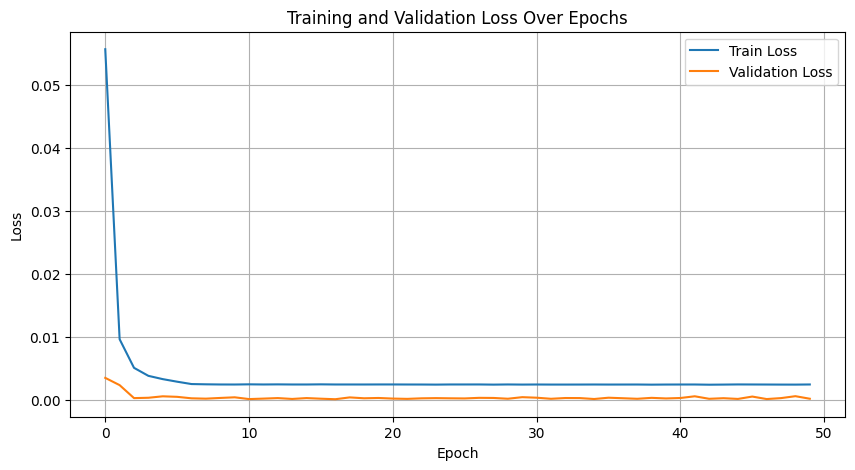

In [43]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_fcn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [44]:
model_path = "soc_fcn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [45]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [46]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.000251
Test MAE: 0.010731
Test StdDev: 0.015694


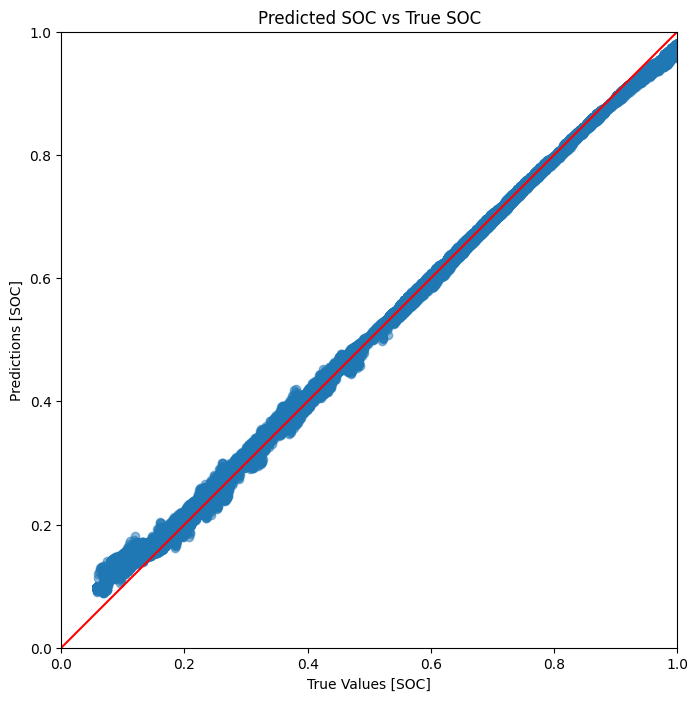

In [47]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

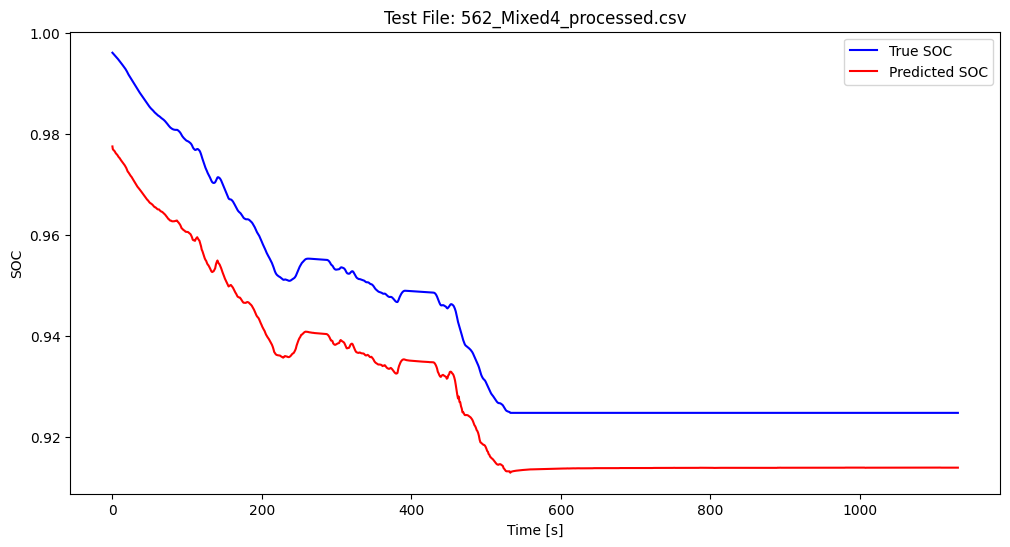

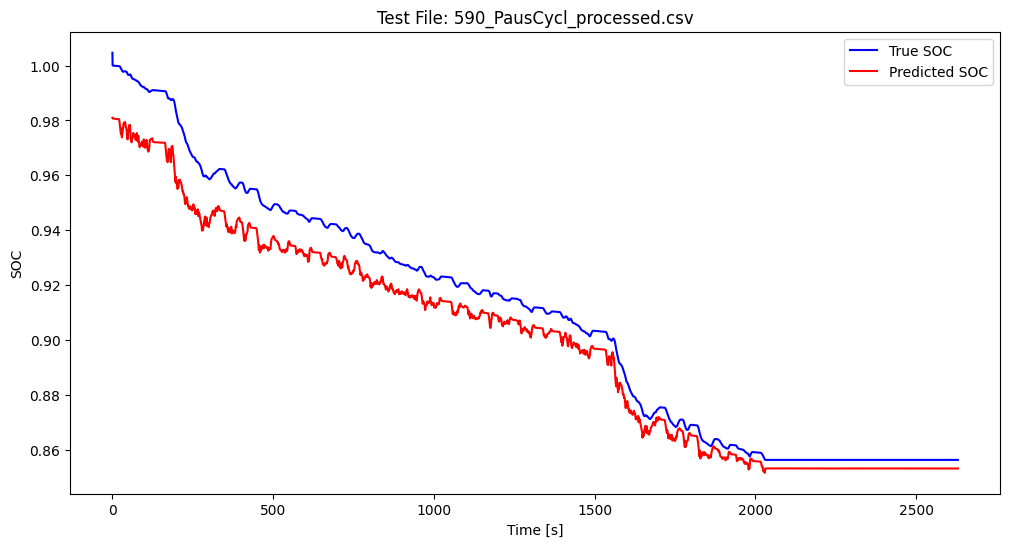

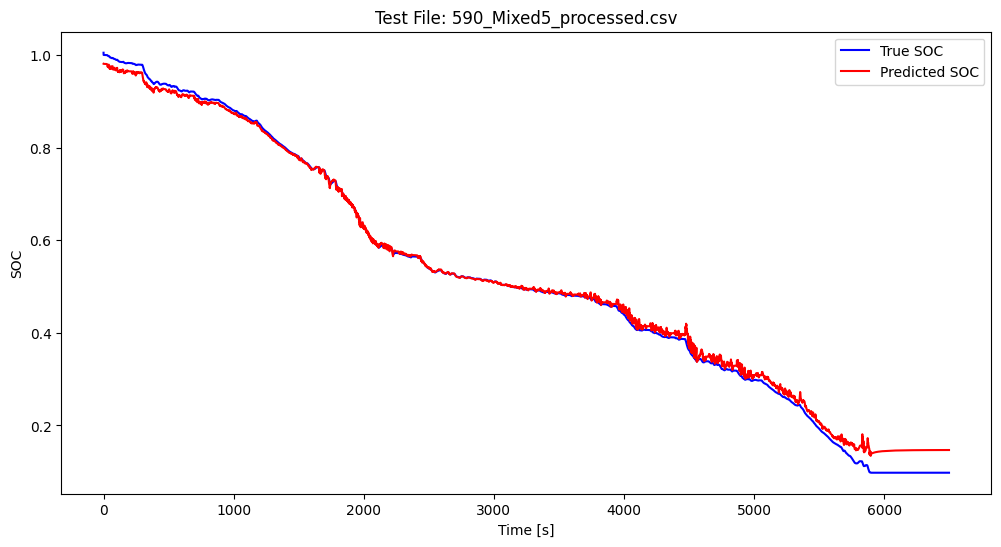

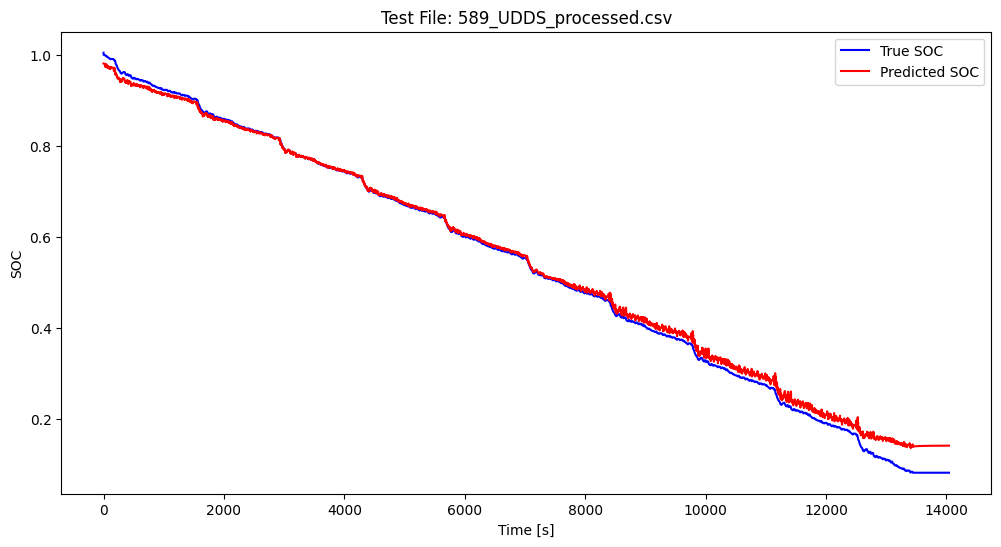

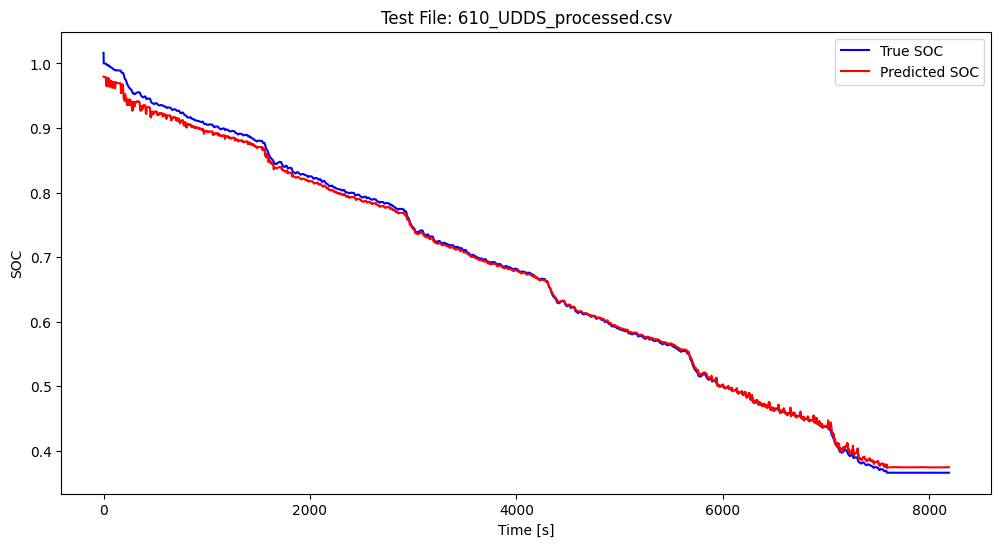

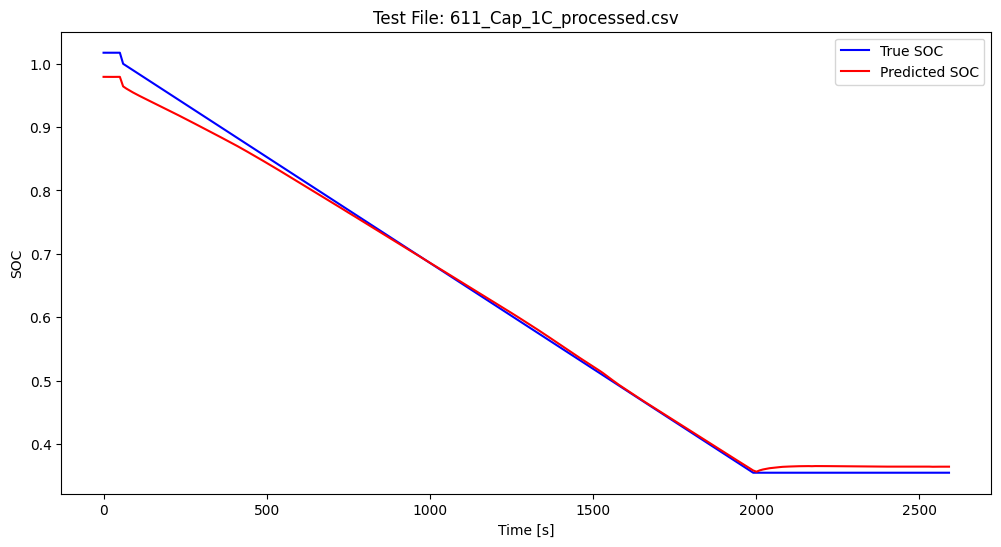

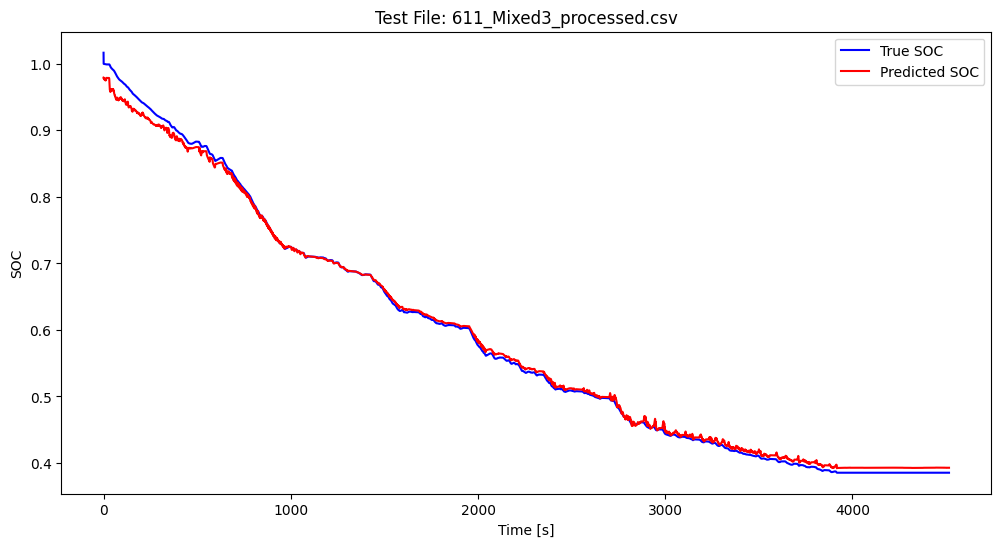

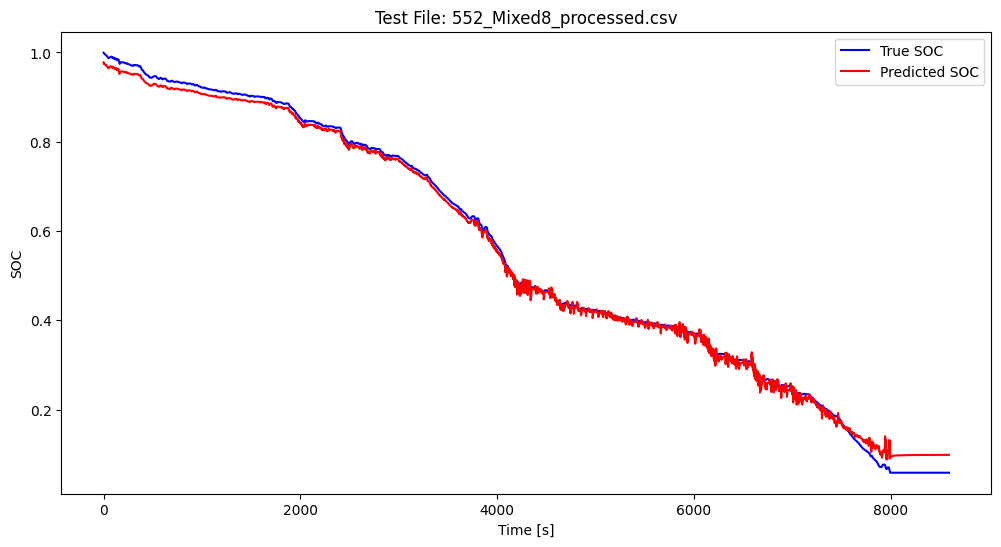

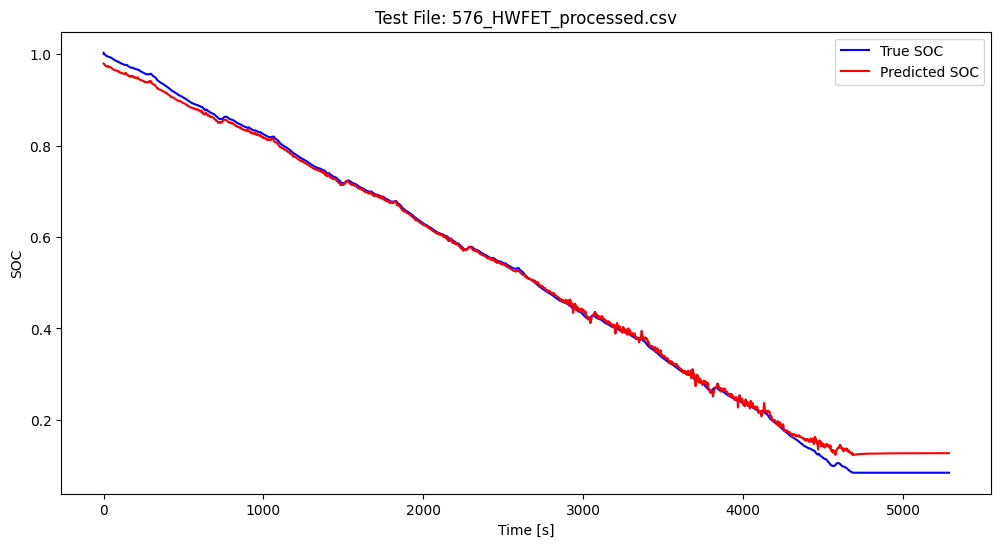

In [48]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)